In [17]:
import json
import os
import pandas as pd
import numpy as np
from scipy.stats import pearsonr

# Load DMM metrics from Excel file
excel_file_path = './inputs/filtered_commit_metrics.xlsx'
dmm_data = pd.read_excel(excel_file_path)

# Select relevant DMM metrics
dmm_metrics = dmm_data[['DMM Unit Complexity', 'DMM Unit Size', 'DMM Unit Interfacing']]

# Define the folder containing JSON files
json_folder_path = './A2A_metrics'

# Dictionary to store correlation results
correlation_results = {}

# Iterate over JSON files in the folder
for file_name in os.listdir(json_folder_path):
    if file_name.endswith('.json'):
        file_path = os.path.join(json_folder_path, file_name)
        with open(file_path, 'r') as file:
            try:
                a2a_scores = []
                data = json.load(file)
                for value in data.values():
                    if value != "NaN":
                        try:
                            a2a_score = float(value)
                            if not np.isnan(a2a_score) and not np.isinf(a2a_score):
                                a2a_scores.append(a2a_score)
                        except ValueError:
                            print(f"Invalid A2A score '{value}' in {file_name}")

                # Check if A2A scores exist
                if not a2a_scores:
                    print(f"No valid A2A scores found in {file_name}")
                    continue

                # Convert DMM metric values to numpy arrays
                dmm_metric_values = dmm_metrics.values.astype(float)[:len(a2a_scores)]

                # Filter out NaN and infinite values from DMM metric values
                valid_indices = ~np.isnan(dmm_metric_values).any(axis=1) & ~np.isinf(dmm_metric_values).any(axis=1)
                dmm_metric_values = dmm_metric_values[valid_indices]
                a2a_scores = np.array(a2a_scores)[valid_indices]

                # Perform Pearson correlation coefficient test
                correlation_results[file_name] = {}
                for col in dmm_metrics.columns:
                    correlation_coefficient, p_value = pearsonr(dmm_metric_values[:, dmm_metrics.columns.get_loc(col)], a2a_scores)
                    correlation_results[file_name][col] = {"correlation_coefficient": correlation_coefficient, "p_value": p_value}

            except Exception as e:
                print(f"Error processing {file_name}: {e}")

# Write correlation results to a JSON file
output_file_path = './correlation_results.json'
with open(output_file_path, 'w') as output_file:
    json.dump(correlation_results, output_file, indent=4)

print(f"Correlation results saved to {output_file_path}")


Correlation results saved to ./correlation_results.json


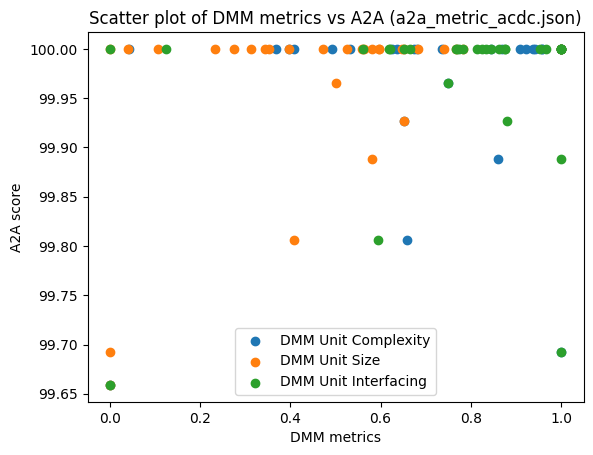

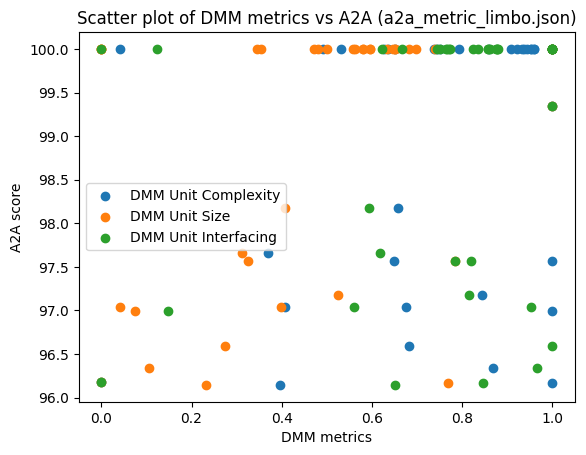

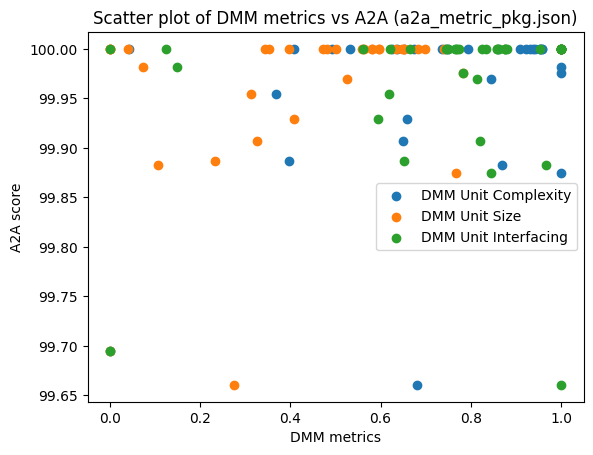

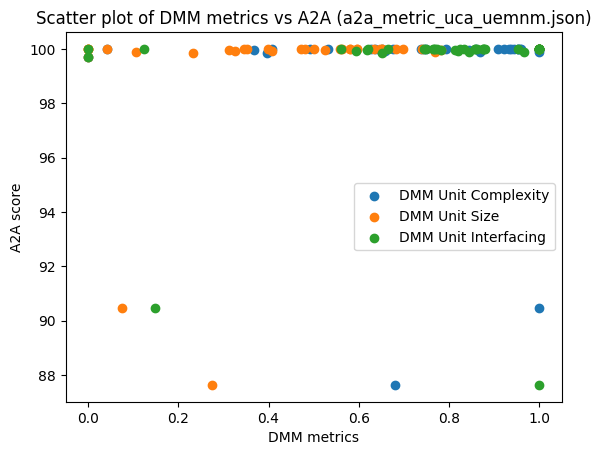

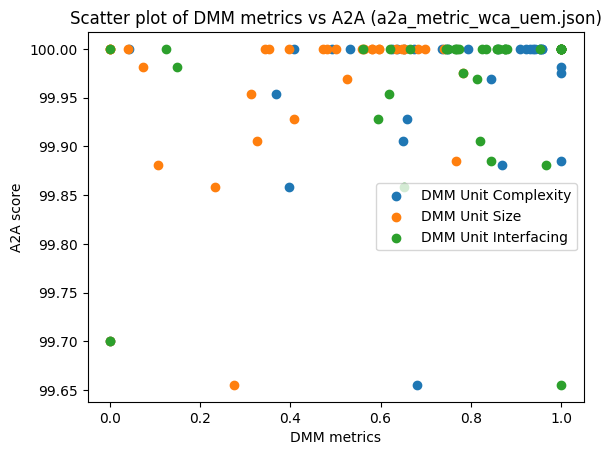

In [5]:
import json
import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import kruskal

# Load DMM metrics from Excel file
excel_file_path = './inputs/filtered_commit_metrics.xlsx'
dmm_data = pd.read_excel(excel_file_path)

# Select relevant DMM metrics
dmm_metrics = dmm_data[['DMM Unit Complexity', 'DMM Unit Size', 'DMM Unit Interfacing']]

# Define the folder containing JSON files
json_folder_path = './A2A_metrics'

# Iterate over JSON files in the folder
for i, file_name in enumerate(os.listdir(json_folder_path), start=1):
    if file_name.endswith('.json'):
        with open(os.path.join(json_folder_path, file_name), 'r') as file:
            a2a_scores = []
            data = json.load(file)
            for key, value in data.items():
                if value == "NaN":
                    continue
                a2a_scores.append(float(value))
        
        # Plot scatter plot for the current JSON file
        plt.figure()
        for col in dmm_metrics.columns:
            plt.scatter(dmm_metrics[col][:len(a2a_scores)], a2a_scores, label=col)
        plt.xlabel('DMM metrics')
        plt.ylabel('A2A score')
        plt.title(f'Scatter plot of DMM metrics vs A2A ({file_name})')
        plt.legend()
        plt.show()

